In [1]:
import os
import sys
import torch as t
from torch import Tensor
import einops
from ipywidgets import interact
import plotly.express as px
from ipywidgets import interact
from pathlib import Path
from IPython.display import display
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
import typeguard

# Make sure exercises are in the path
chapter = r"chapter0_fundamentals"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part1_ray_tracing"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow
from part1_ray_tracing.utils import render_lines_with_plotly, setup_widget_fig_ray, setup_widget_fig_triangle
import part1_ray_tracing.tests as tests

# Raytracing

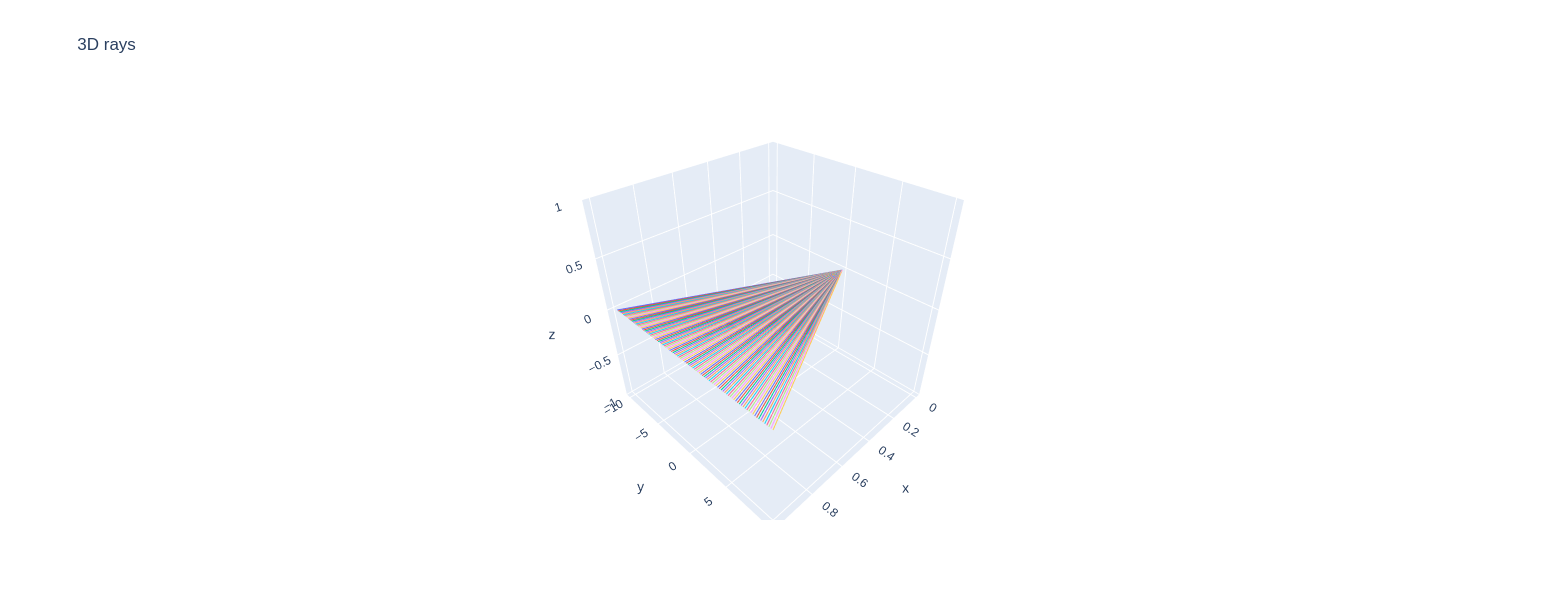

In [5]:
def make_rays_1d(num_pixels: int, y_limit: float) -> t.Tensor:
    '''
    num_pixels: The number of pixels in the y dimension. Since there is one ray per pixel, this is also the number of rays.
    y_limit: At x=1, the rays should extend from -y_limit to +y_limit, inclusive of both endpoints.

    Returns: shape (num_pixels, num_points=2, num_dim=3) where the num_points dimension contains (origin, direction) and the num_dim dimension contains xyz.

    Example of make_rays_1d(9, 1.0): [
        [[0, 0, 0], [1, -1.0, 0]],
        [[0, 0, 0], [1, -0.75, 0]],
        [[0, 0, 0], [1, -0.5, 0]],
        ...
        [[0, 0, 0], [1, 0.75, 0]],
        [[0, 0, 0], [1, 1, 0]],
    ]
    '''
    rays_1d = t.zeros((num_pixels, 2, 3), dtype=t.float32)
    rays_1d[:, 1, 0] = 1
    rays_1d[:, 1, 1] = t.linspace(-y_limit, y_limit, num_pixels)
    return rays_1d

rays1d = make_rays_1d(100, 10)

fig = render_lines_with_plotly(rays1d)

In [9]:
fig = setup_widget_fig_ray()
display(fig)

@interact
def response(seed=(0, 10, 1), v=(-2.0, 2.0, 0.01)):
    t.manual_seed(seed)
    L_1, L_2 = t.rand(2, 2)
    P = lambda v: L_1 + v * (L_2 - L_1)
    x, y = zip(P(-2), P(2))
    with fig.batch_update(): 
        fig.data[0].update({"x": x, "y": y}) 
        fig.data[1].update({"x": [L_1[0], L_2[0]], "y": [L_1[1], L_2[1]]}) 
        fig.data[2].update({"x": [P(v)[0]], "y": [P(v)[1]]})


FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'e1471cf6-9619-40b1-97f1-75acaf7b04f6', 'x': [], 'y': []},
             {'marker': {'size': 12},
              'mode': 'markers',
              'type': 'scatter',
              'uid': '544bebf6-5039-493b-b2ba-ea719702d4c7',
              'x': [],
              'y': []},
             {'marker': {'size': 12, 'symbol': 'x'},
              'mode': 'markers',
              'type': 'scatter',
              'uid': '266162c0-96d0-4a38-8271-d416913840c3',
              'x': [],
              'y': []}],
    'layout': {'height': 500,
               'showlegend': False,
               'template': '...',
               'width': 600,
               'xaxis': {'range': [-1.5, 2.5]},
               'yaxis': {'range': [-1.5, 2.5]}}
})

interactive(children=(IntSlider(value=5, description='seed', max=10), FloatSlider(value=0.0, description='v', …

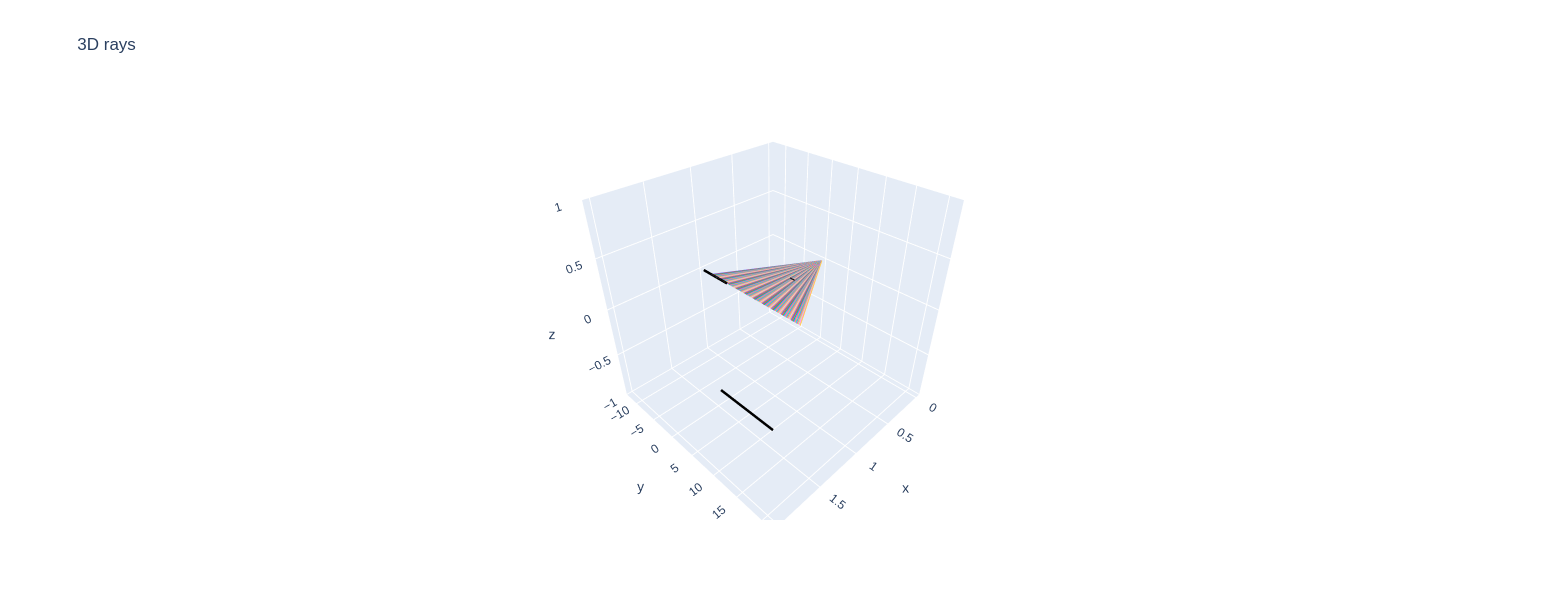

In [11]:
segments = t.tensor([
    [[1.0, -12.0, 0.0], [1, -6.0, 0.0]], 
    [[0.5, 0.1, 0.0], [0.5, 1.15, 0.0]], 
    [[2, 12.0, 0.0], [2, 21.0, 0.0]]
])
render_lines_with_plotly(rays1d, segments)

In [31]:
def intersect_ray_1d(ray: t.Tensor, segment: t.Tensor) -> bool:
    '''
    ray: shape (n_points=2, n_dim=3)  # O, D points
    segment: shape (n_points=2, n_dim=3)  # L_1, L_2 points

    Return True if the ray intersects the segment.
    '''
    o, d = ray
    l1, l2 = segment

    A = t.stack([d, l1 - l2], dim=1)[:2] # Ditch z-coordinate
    b = (l1 - o)[:2]  # Ditch z-coordinate
    try:
        u, v= [z.item() for z in t.linalg.solve(A, b)]
    except Exception:
        return False
    
    return (u >= 0) and (0 <= v <= 1)


tests.test_intersect_ray_1d(intersect_ray_1d)
tests.test_intersect_ray_1d_special_case(intersect_ray_1d)

All tests in `test_intersect_ray_1d` passed!
All tests in `test_intersect_ray_1d_special_case` passed!


# Batched Operations